In this notebook another model for topological superconductivity in one dimension is introduced. The model considers a nanowire with strong spin-orbit coupling (SOC) in proximity contact with superconductivity and ferromagnetism. The proximity induced ferromagnetic order breaks time reversal symmetry, similarly as an external magnetic field does. The model was introduced in the articles by [Lutchyn](https://link.aps.org/doi/10.1103/PhysRevLett.105.077001) et al. and [Oreg](https://link.aps.org/doi/10.1103/PhysRevLett.105.177002) et al. Devices aimed to realize this model have already been frabricated, with some features attributed to Majorana zero modes (MZMs) widely reported, [Mourik](https://www.science.org/doi/abs/10.1126/science.1222360), [Deng](https://www.science.org/doi/10.1126/science.aaf3961). However, a consensus by the scientific community that these findings confirm the emergence of MZMs  is still lacking.

# Outline
- [1 - The Lutchyn-Oreg hamiltonian](#1)
- [2 - Building the model with kwant](#2)
  - [2.1 Sparse diagonalization](#2.1)
- [3 - Majorana and bulk states](#3)
- [4 - Phases of the Lutchyn-Oreg hamiltonian](#4)

<a name="1"></a>
# The Lutchyn-Oreg hamiltonian

The hamiltonian of the ferromagnetic-superconducting nanowire with strong SOC reads

$$\mathcal{H} = \Bigl[-\frac{\hbar^2}{2m^*} \partial_x^2 + i\alpha\partial_x\sigma_z  - \mu\Bigl]\tau_z + \mathbf{m}\cdot\boldsymbol{\sigma} + \Delta\tau_x,$$

where $m^*$ is the effective mass, $\alpha$ the spin-orbit coupling, $\mu$ the chemical potential, $\mathbf{m}=\!m_0\bigl(\,\sin{\theta}\cos{\phi},\sin{\theta}\sin{\phi},\cos{\theta}\,\bigr)$ the magnetization with an arbitrary direction, and $\Delta$ the superconducting gap. Moreover, ${\boldsymbol \sigma}=(\sigma_x,\sigma_y,\sigma_z)$ and ${\boldsymbol \tau}=(\tau_x,\tau_y,\tau_z)$ are Pauli matrices acting in the spin and Nambu space, respectively. Values of $m^*$ and $\alpha$ for nanowires of InAs and InSb are given in the table below, [InAs-InSb](https://arxiv.org/abs/1707.04899). 

<table style="width:60%">
    <tr>
        <th style="width:40%">Semiconductors</th>
        <th>   InAs   </th>
        <th>   InSb   </th>
    </tr>
    <tr>
        <td>effective mass $m^*$</td>
        <td>0.023$m_e$</td>
        <td>0.014$m_e$</td>
    </tr>
    <tr>
        <td>spin-orbit coupling $\alpha$</td>
        <td>20-80 $meV\cdot nm$</td>
        <td>20-100 $meV\cdot nm$</td>
    </tr>
    <tr>
        <td>spin-orbit energy $E_{so}=\frac{m^*\alpha^2}{2\hbar^2}$</td>
        <td>0.05 - 1 $meV$</td>
        <td>0.05 - 1 $meV$</td>
    </tr>
    <tr>
        <td>spin-orbit length $\lambda_{so}=\frac{\hbar^2}{\alpha m^*}$</td>
        <td>180 - 40 $nm$</td>
        <td>230 - 50 $nm$</td>
    </tr>
    <tr>
        <th>Superconductors</th>
        <th>   Al   </th>
        <th>  NbTiN  </th>
    </tr>
    <tr>
        <td>superconducting gap $\Delta$</td>
        <td>0.2 $meV$</td>
        <td>3 $meV$</td>
    </tr>
    <tr>
        <td>critical field $B_c$</td>
        <td>10 $mT$</td>
        <td>10 $T$</td>
    </tr>
    <tr>
        <td>critical temperature $T_c$</td>
        <td>1.2 $K$</td>
        <td>15 $K$</td>
    </tr>

</table>

With the energy and length scales introduced above let's obtain the dimensionless hamiltonian,

\begin{equation}
\frac{\mathcal{H}}{E_{so}} = \Bigl[
-\lambda^2_{so} \partial_x^2 + 2i\lambda_{so}\partial_x\sigma_z -\frac{\mu}{E_{so}}\Bigl]\tau_z 
+\frac{\mathbf{m}}{E_{so}}\cdot\boldsymbol{\sigma} + \frac{\Delta}{E_{so}}\tau_x.
\label{dimham}\tag{1}
\end{equation}

For the sake of simplicity from now on we will drop $E_{so}$ in the denominator and assume that all quantities are in dimensionless units. The system given by hamiltonian (\ref{dimham}) will be implemented within the tight binding formalism. The python package [kwant](https://kwant-project.org/) provides a simple and elegant way to build not only tight binding hamiltonians but also to solve transport related problems. The lines of code below import the necessary packages and files for this simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import kwant.continuum
import time
from scipy.linalg import eigh
import supp_func_kwant as sfk

from ipywidgets import interactive

C:\Users\victo\anaconda3\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


<a name="2"></a>
# Building the model with kwant

Given that the Lutchyn-Oreg hamiltonian is provided in terms of the continuous operators $\mathbf{p}$ and $\mathbf{r}$, i.e. in a continuous notation, we use the [continuum](https://kwant-project.org/doc/1/reference/kwant.continuum) module of kwant to declare and build this hamiltonian.

In [2]:
string_ham = """
    (k_x**2 - mu) * kron(sigma_z, sigma_0)
    - 2 * k_x * kron(sigma_z, sigma_z)
    + Delta * kron(sigma_x, sigma_0)
    + m_x(m0,theta,phi) * kron(sigma_0, sigma_x)
    + m_y(m0,theta,phi) * kron(sigma_0, sigma_y)
    + m_z(m0,theta,phi) * kron(sigma_0, sigma_z)
"""

hamiltonian = kwant.continuum.sympify(string_ham)
hamiltonian

Matrix([
[ -mu + m_z(m0, theta, phi) - 2*k_x + k_x**2, m_x(m0, theta, phi) - I*m_y(m0, theta, phi),                                        Delta,                                             0],
[m_x(m0, theta, phi) + I*m_y(m0, theta, phi),  -mu - m_z(m0, theta, phi) + 2*k_x + k_x**2,                                            0,                                         Delta],
[                                      Delta,                                           0, m_z(m0, theta, phi) + 2*k_x - (-mu + k_x**2),   m_x(m0, theta, phi) - I*m_y(m0, theta, phi)],
[                                          0,                                       Delta,  m_x(m0, theta, phi) + I*m_y(m0, theta, phi), -m_z(m0, theta, phi) - 2*k_x - (-mu + k_x**2)]])

Notice that `string_ham` declares the hamiltonian as string. Moreover, the components of the magnetization appear in a notation resembling that of a mathematical function, e.g. `m_x(m0,theta,phi)`. They are treated by kwant exactly in that way and the python functions defining the magnetization are found in the external file `supp_func_kwant.py`. 

In [3]:
alat=0.25
Lleft=0;  Lright=32
default = dict(Delta=2.0, mu=4.5, m0=3.0, theta=0.4, phi=0.2, 
               m_x=sfk.mx_homog, m_y=sfk.my_homog, m_z=sfk.mz_homog,
               L1=Lleft, L2=Lright)

To avoid saturating this notebook with lines of code, I am including in the external file `supp_func_kwant.py` functions doing what it was already discussed in other notebooks. As an example the function `K_syst()` builds and finalizes a tight binding model from a continuous hamiltonian.  

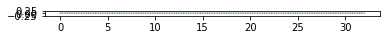

Plotting the nodes and vertices of the lattice


In [4]:
latsyst = sfk.K_syst(Lleft,Lright, alat, str_hamil=string_ham, finite=True)
kwant.plot(latsyst)
print('Plotting the nodes and vertices of the lattice')

<a name="2.1"></a>
## Sparse diagonalization

The system that we are studying is getting bigger. That's the result of more degrees of freedom included in the hamiltonian. Assuming a lattice with same number of sites, the size of the Lutchyn-Oreg hamiltonian will quadruple the size of the Kitaev hamiltonian. Sparse diagonalization is a convenient strategy to deal with large matrices and keep low the memory comsumption. In the cell below we compute the time that takes to calculate $n$ energies around zero in the Lutchyn-Oreg hamiltonian. The plot of computing time vs $n$ is shown further below.    

In [5]:
tlist = []
knlist = [nn for nn in range(16,40,1)]
for ii in knlist:
    start = time.perf_counter()
    sfk.diag_solver(latsyst,'m0',2.0,ii,default,False)
    end = time.perf_counter()
    tlist.append(end-start)

Text(0.5, 0, '$n$ (number of roots)')

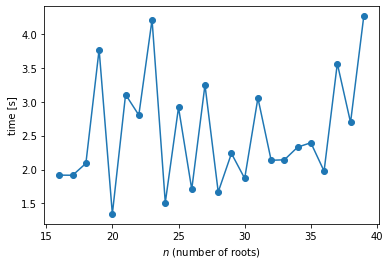

In [6]:
plt.plot(np.array(knlist),np.array(tlist),'-o')
plt.ylabel('time [s]')
plt.xlabel(r'$n$'+' (number of roots)')

<a name="3"></a>
# Majorana and bulk states

Let's use the diagonalization function `diag_solver()` to calculate the spectrum of the Lutchy-Oreg hamiltonian as a function of $m_0.$ As in the Kitaev case let's calculate the spatial profile of some states at different phases as well. The function `energy_wvf()` might take some minutes to complete the calculation. 

In [7]:
def energy_wvf(varr,kn,m0min,m0max):

    Emtx = np.zeros((len(varr),kn))
    if m0min < varr[0] or m0min > varr[-1]:
        ia = 0
    else:
        ia = int((m0min-varr[0])/(varr[1]-varr[0]))
    if m0max < varr[0] or m0max > varr[-1]:
        ib = len(varr) + 1
    else:
        ib = int((m0max-varr[0])/(varr[1]-varr[0]))
    
    ilist = [ia,ib]
    vlist = []
    
    for ii in range(len(varr)):
        
        if ii == ia or ii == ib:
            En, vec =sfk.diag_solver(latsyst,'m0',varr[ii],kn,default,True)
            Enarrinds = En.argsort()
            Emtx[ii,::] = En[Enarrinds]
            vec = vec[::,Enarrinds]
            vlist.append(vec)
        else:    
            En =sfk.diag_solver(latsyst,'m0',varr[ii],kn,default,False)
            En = np.sort(En)
            Emtx[ii,::] = En[::]
    
    rho = kwant.operator.Density(latsyst)
    
    fig, sub = plt.subplots(1,3, figsize=(12,4))    
    sub[0].plot(varr,Emtx)
    
    titls=['(a)','(b)','(c)']
    nhlf = int(0.5*kn)
    xarr = np.linspace(Lleft,Lright,int((Lright-Lleft)/alat)+1)
    for ii in range(2):
        sub[0].plot(varr[ilist[ii]]*np.ones(7),np.linspace(Emtx[0,0],Emtx[0,-1],7), 
                    '--k', alpha=0.7)
        sub[ii+1].set_xlabel(r'$x/\lambda_{so}$')
        sub[ii+1].set_ylabel(r'$|\psi(x)|^2$',labelpad=-2)
        for jj in range(3):
            En = Emtx[ilist[ii],nhlf+jj]
            sub[ii+1].plot(xarr,rho(vlist[ii][::,int(0.5*kn)+jj]),label='E='+str.format('{:.3f}',En))
        sub[ii+1].set_title(titls[ii+1]+r'$\,\,m_0/E_{so}=$'+str.format('{:.2f}',varr[ilist[ii]]))
        sub[ii+1].legend(frameon=False)
    
    sub[0].set_title(titls[0])
    sub[0].set_ylim(Emtx[0,0],Emtx[0,-1])
    sub[0].set_ylabel(r'$E/E_{so}$')
    sub[0].set_xlabel(r'$m_0/E_{so}$')
    
    fig.subplots_adjust(wspace=0.27)    

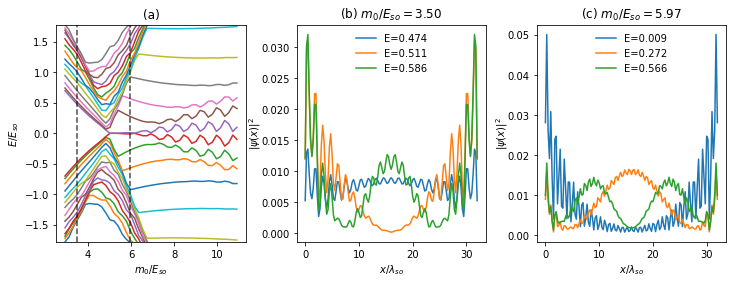

In [8]:
m0c = np.sqrt(default.get('Delta')**2 + default.get('mu')**2)
numroots = 28;  npoints = 43
l_lcut = 3.5; r_lcut=6.0
varr = np.linspace(m0c-2,m0c+6,npoints)
energy_wvf(varr,numroots,l_lcut,r_lcut)

(a) Energies of the ferromagnetic-superconducting nanowire as a function of $m_0$. The gap is closing around $m_0\,/E_{so}=5$, hence indicating the existence of two distinct phases. (b) Plot of some bulk states in the phase $m_0\,/E_{so}<5$ (the topologically trivial phase) (c) Plot of the edge state (Majorana) and two bulk states in the phase $m_0\,/E_{so}>5$ (the topologically non-trivial phase). Notice that away from the transition line the energy of the pair of Majoranas starts oscillating around zero and with increasing amplitude. That's due to the hybridization between the Majoranas at the edges of the nanowire [Das Sarma et al.](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.86.220506) and [Rainis et al.](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.87.024515)   

<a name="4"></a>
# Phases of the Lutchyn-Oreg hamiltonian

In this section we calculate the phase diagram of the ferromagnetic-superconducting nanowire as a function of $m_0$, chemical potential $\mu$, and precession cone angle $\theta$. We follow a similar procedure as in the Kitaev case, by calculating the energies of the Lutchyn-Oreg hamiltonian in $k$ space.

In [5]:
perlat = sfk.K_syst(Lleft,Lright, alat, str_hamil=string_ham, finite=False)

In [6]:
def spect_diagram(chem,m_zero,polar):

    default['mu'] = chem
    default['m0'] = m_zero
    default['theta'] = polar
    
    xlim=8.0
    D0 = default.get('Delta')
    m0arr = np.linspace(D0,xlim,37)
    
    D0arr = D0*np.ones(len(m0arr))
    muarr = np.sqrt(m0arr**2-D0arr**2)
    gapless = D0/np.cos(polar*np.pi)
    
    kxarr = np.linspace(-1.4,1.4,177)
    Elist = []
    for kx in kxarr:
        default['k_x'] = kx
        ham = perlat.hamiltonian_submatrix(params=default, sparse=False)
        Evals = eigh(ham, eigvals_only=True)
        Elist.append(Evals)

        Emtx = np.array(Elist)
        
    fig, sub = plt.subplots(1,2, figsize=(9,4))

    for ii in range(2):
        sub[1].plot(m0arr,muarr*(-1)**ii, '--b', lw=2)
            
    sub[0].plot(kxarr,Emtx)
    sub[0].plot(np.linspace(kxarr[0],kxarr[-1],17), np.zeros(17), '--k', alpha=0.4)

    sub[0].set_xlabel(r'$k_xa$', fontsize=12)
    sub[0].set_ylim(-6,6)
    
    vertline = np.linspace(-9,9,len(m0arr))
    sub[1].plot(gapless*np.ones(len(m0arr)),vertline, '--g', lw=2.2)
    sub[1].scatter(m_zero,chem, s=50, color='red')
    
    # To fill the lines the x axis (m0) has to be divided in three segments
    # warning: keep the same number of points in lm0arr, cm0arr, and rm0arr.
    lm0arr = np.linspace(0,D0,37, endpoint=False)
    cm0arr = np.linspace(D0,gapless,37)
    rm0arr = np.linspace(gapless,xlim,37)
    topline = xlim*np.ones(len(cm0arr))
    cmuarr = np.sqrt(cm0arr**2-D0**2*np.ones(len(cm0arr)))
    rmuarr = np.sqrt(rm0arr**2-D0**2*np.ones(len(rm0arr)))
    
    sub[1].fill_between(rm0arr, rmuarr, topline, color='lime', alpha=0.5)
    sub[1].fill_between(rm0arr, -rmuarr, -topline, color='lime', alpha=0.5)
    sub[1].fill_between(rm0arr, -rmuarr, rmuarr, color='orange', alpha=0.5)
    sub[1].fill_between(cm0arr, -cmuarr, cmuarr, color='purple', alpha=0.5)
    sub[1].fill_between(cm0arr, cmuarr, topline, color='cyan', alpha=0.5)
    sub[1].fill_between(cm0arr, -cmuarr, -topline, color='cyan', alpha=0.5)
    sub[1].fill_between(lm0arr, -topline, topline, color='cyan', alpha=0.5)

    sub[0].set_title('Normal lead')
    sub[0].set_ylabel(r'$E/E_{SO}$', fontsize=12)
    sub[1].set_xlabel(r'$m_0/E_{so}$', fontsize=12)
    sub[1].set_ylabel(r'$\frac{\mu}{E_{so}}$', fontsize=18, rotation='horizontal',labelpad=6)
    sub[1].set_xlim(0,xlim)
    sub[1].set_ylim(-xlim,xlim)
    sub[1].set_title('Phase diagram')
    sub[1].text(0.5,0.5*xlim,'TG', fontsize=12, color='black')
    sub[1].text(1.05*gapless,0.0*xlim,'NTGL', fontsize=12, color='black')
    sub[1].text(1.05*gapless,0.85*xlim,'TGL', fontsize=12, color='black')
    sub[1].text(0.7*gapless,-0.15*xlim,'NTG', fontsize=12, color='black')
    
    plt.show()

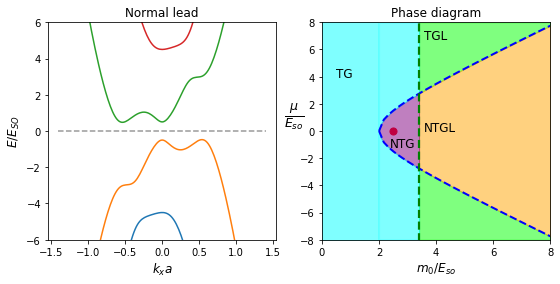

In [7]:
spect_diagram(chem=0.0,m_zero=2.5,polar=0.3)

In [8]:
w = interactive(spect_diagram, chem=(-5.0,5.0), m_zero=(0.0,5.0), polar=(0.1,0.5))
display(w)

interactive(children=(FloatSlider(value=0.0, description='chem', max=5.0, min=-5.0), FloatSlider(value=2.5, deâ€¦

Energy spectrum of the ferromagnetic-superconducting nanowire as a function of linear momentum $k_x$. Phase diagram of the hybrid nanowire as a function of chemical potential $\mu$ and $m_0$. Users can slide the buttons `chem`, `m_zero`, and `polar` to change the parameters $\mu$, $m_0$, and $\theta$, respectively. The transition line $\mu^2 +\Delta_0^2 = m_0^2$ separates the topologically trival and non-trivial phases. On the other hand, the transition line $\Delta_0=m_0\cos{\theta}$ separates the gapped and gapless phases. TG (NTG) stands for trival gapped (nontrivial gapped), and TGL (NTGL) for trvial gapless (nontrivial gapless).   

To obtain the transition lines we analyze the eigenvalue problem at zero energy. Let's do that with the python library SymPy.

In [12]:
import sympy as sp

In [13]:
p = sp.Symbol('p')

musc = sp.Symbol('\\mu', real=True)

D0, mab, mz, phi = sp.symbols('\\Delta_0 m_{ab} m_z \\phi', positive=True)

H = sp.Matrix([[p**2 -2*p -musc +mz, mab*sp.exp(-1j*phi), D0, 0],
            [mab*sp.exp(1j*phi), p**2 +2*p -musc -mz, 0, D0],
            [D0, 0, 2*p -p**2 +musc +mz, mab*sp.exp(-1j*phi)],
            [0, D0, mab*sp.exp(1j*phi), -2*p -p**2 +musc -mz]])

H

Matrix([
[-\mu + m_z + p**2 - 2*p, m_{ab}*exp(-1.0*I*\phi),               \Delta_0,                       0],
[ m_{ab}*exp(1.0*I*\phi), -\mu - m_z + p**2 + 2*p,                      0,                \Delta_0],
[               \Delta_0,                       0, \mu + m_z - p**2 + 2*p, m_{ab}*exp(-1.0*I*\phi)],
[                      0,                \Delta_0, m_{ab}*exp(1.0*I*\phi),  \mu - m_z - p**2 - 2*p]])

Analytical calculations show the following factor decomposition of the characteristic equation 

\begin{equation}
\bigl((p^2 -\mu)^2 +(2ip -\Delta_e)^2 -m_{ab}^2 \bigr) 
\bigl((p^2 -\mu)^2 +(2ip +\Delta_e)^2 -m_{ab}^2\bigr)=0,
\label{chareq}\tag{2}
\end{equation}

where $\Delta_e = \sqrt{\Delta_0^2 - m_z^2}$. Let's check below if this factorization is ok.

In [14]:
prodone = (p**2 - musc)**2 + (2*1j*p -sp.sqrt(D0**2 -mz**2))**2 -mab**2
prodtwo = (p**2 - musc)**2 + (2*1j*p +sp.sqrt(D0**2 -mz**2))**2 -mab**2
sp.simplify(H.det() - prodone*prodtwo)

0

Other way to write Eq. (2) is as follows,

\begin{eqnarray}
(p^2 -\mu)^2 +(2ip \mp\Delta_e)^2 -m_{ab}^2=0,\nonumber\\
p^4 -2(\mu+2)p^2 \mp4i\Delta_ep +\mu^2 +\Delta_e^2 -m_{ab}^2=0.\\
\label{4thor}\tag{3}
\end{eqnarray}

When the condition $\mu^2 +\Delta_e^2 -m_{ab}^2=0$ is met, $p=0$ becomes a root to the polynomial above. This condition defines one of the transition lines in the diagram, $\mu^2 +\Delta_0^2 = m_0^2$. The second transition line is defined by the condition $\Delta_e = 0$ $\bigl(\Delta_0=m_0\cos{\theta}\bigr)$, in this case Eq. (\ref{4thor}) becomes a biquadratic equation whose solutions read  

In [15]:
sp.roots(p**2 - 2*(musc+2)*p + musc**2+D0**2-mz**2-mab**2,p)

{\mu - sqrt(-\Delta_0**2 + 4*\mu + m_z**2 + m_{ab}**2 + 4) + 2: 1,
 \mu + sqrt(-\Delta_0**2 + 4*\mu + m_z**2 + m_{ab}**2 + 4) + 2: 1}

$$p^2= 2 +\mu \mp \sqrt{4 + 4\mu +  m_0^2 -\Delta_0^2 }.$$